In [1]:
# !pip install pmdarima

In [2]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

import os
from IPython.display import Image

import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from fbprophet import Prophet 

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
from IPython.display import display, Math, Latex


warnings.simplefilter(action='ignore', category= FutureWarning)

In [3]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)}) 


## $X_t−0.9*X_{t-1}=\epsilon_t$
Our ARMA equation: Letf side is AR and right side is MA process


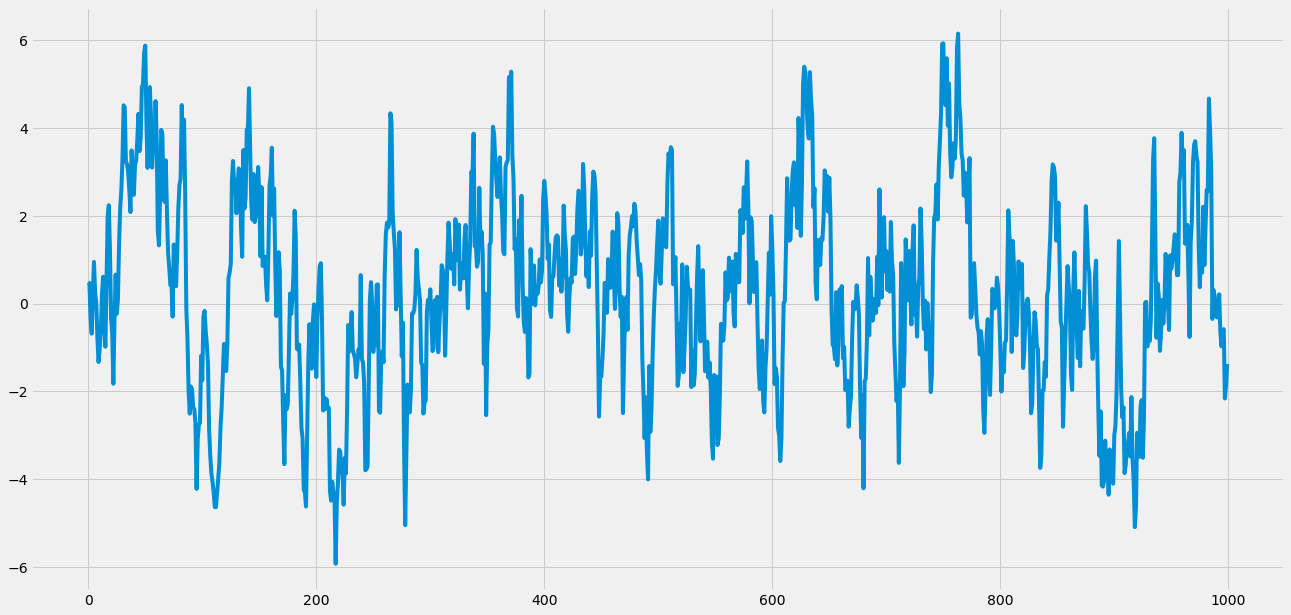

In [4]:
ar1 = np.array([1,-0.9])
ma1 = np.array([1])

AR_object1 = ArmaProcess(ar1,ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

## ACF for MA order

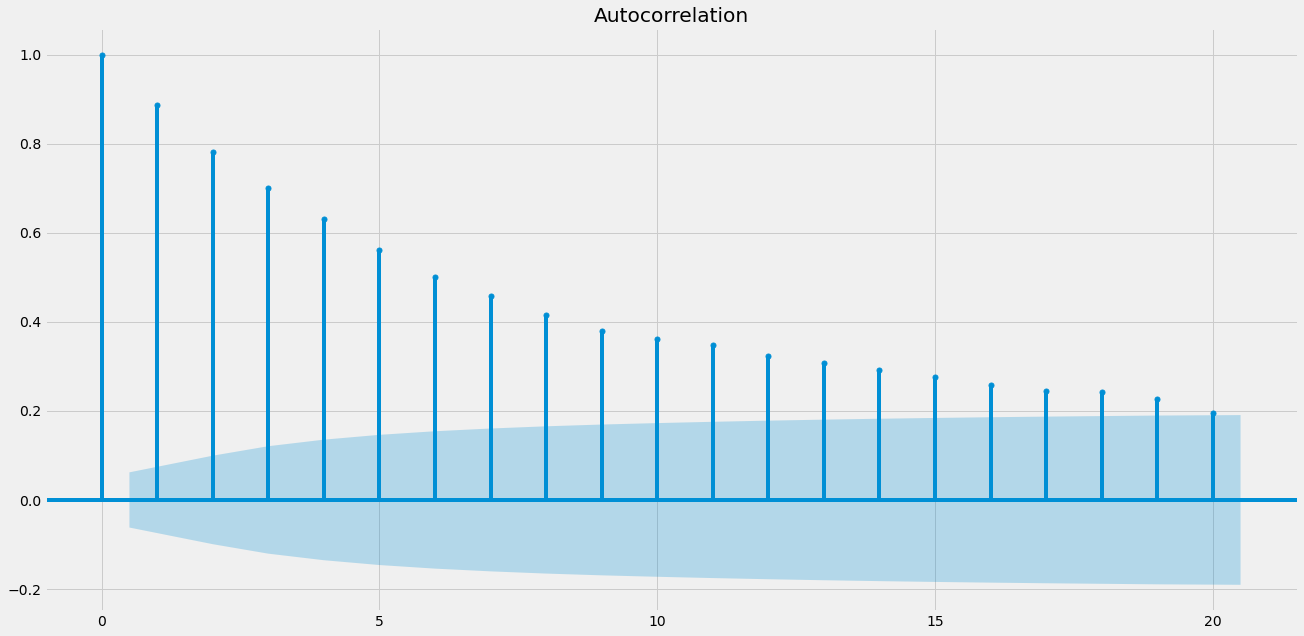

In [5]:
plot_acf(simulated_data_1, lags = 20)
plt.show()

## PACF for AR order

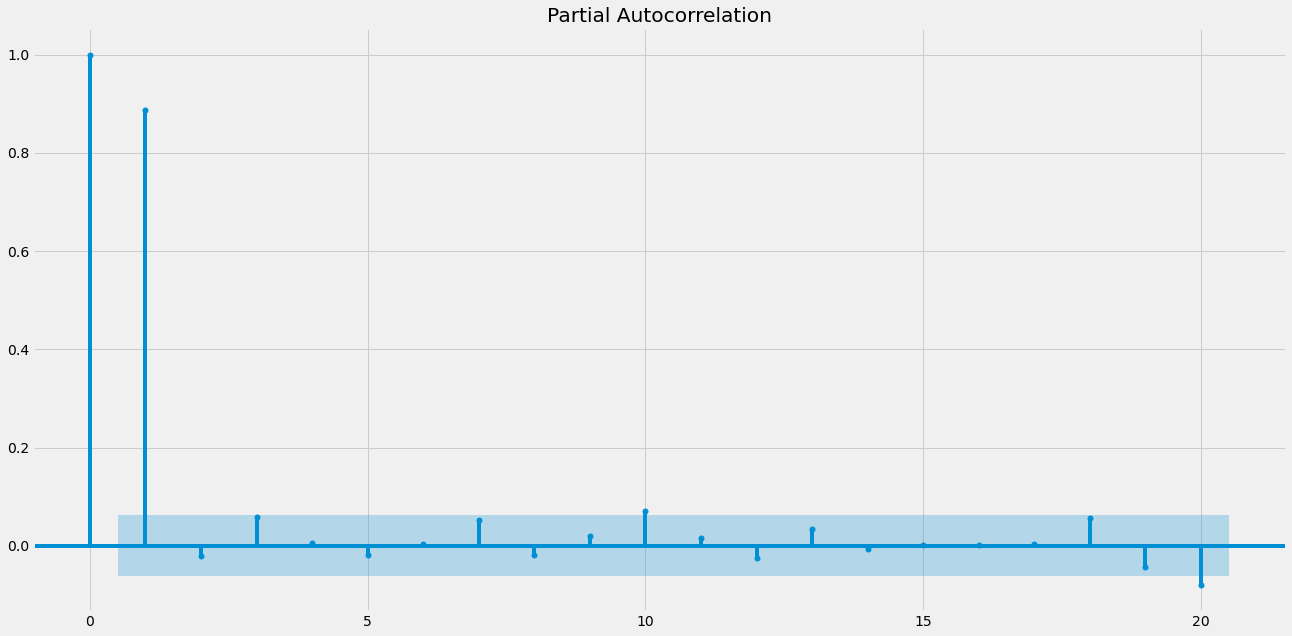

In [6]:
plot_pacf(simulated_data_1, lags = 20)
plt.show()

## MA Process : $X_t = \epsilon_t +  0.9 \epsilon_{t-1} $


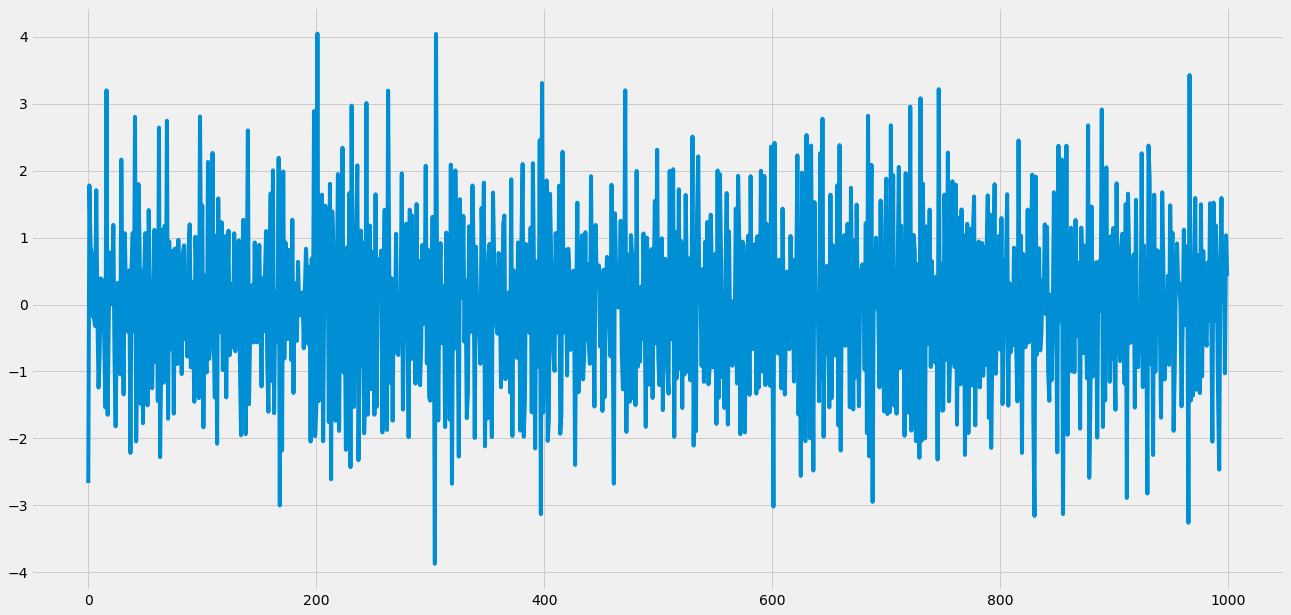

In [7]:
ar1 = np.array([1])
ma1 = np.array([1,-0.9])
MA_object1 = ArmaProcess(ar1,ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)
plt.show()

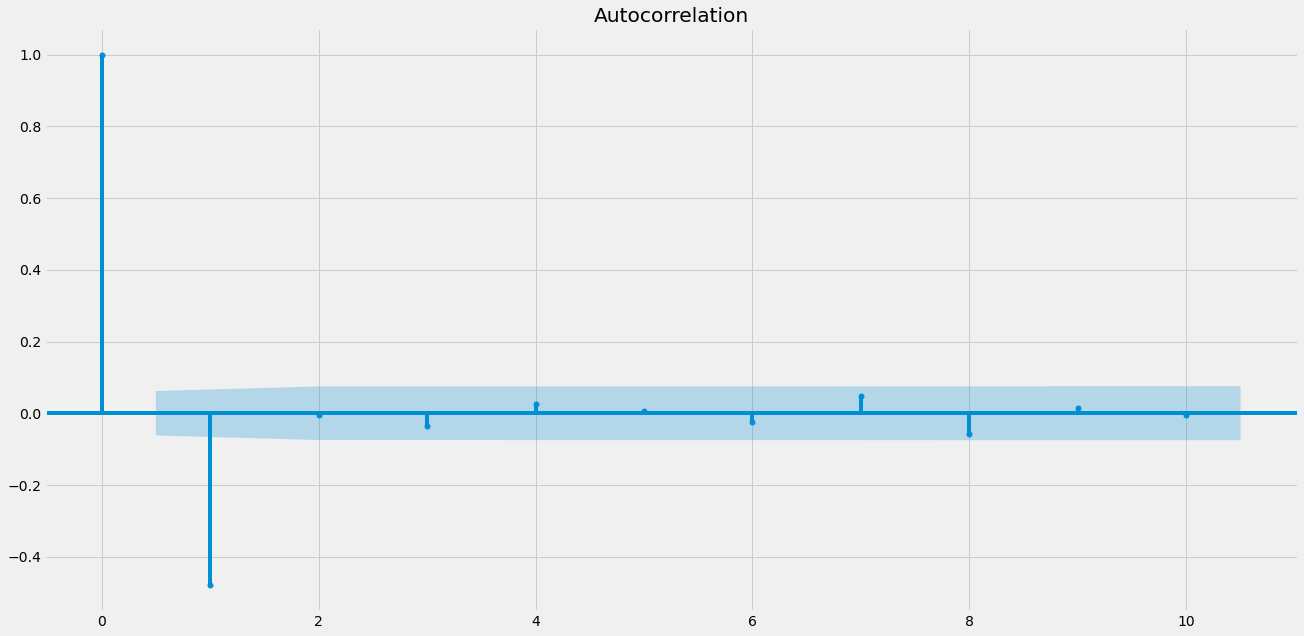

In [8]:
plot_acf(simulated_data_1,lags=10)
plt.show()

## clearly order 1 MA process

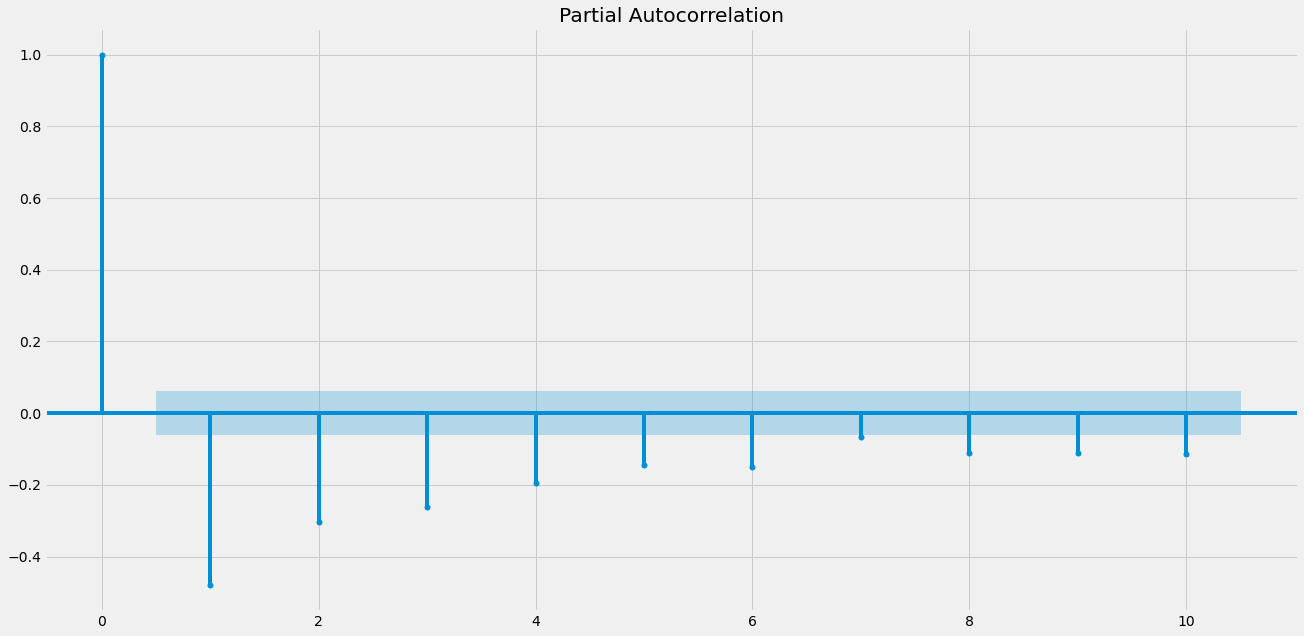

In [9]:
plot_pacf(simulated_data_1,lags=10)
plt.show()

## cant say anything about the order in the AR process

## ARMA Forecasting

<AxesSubplot:xlabel='date'>

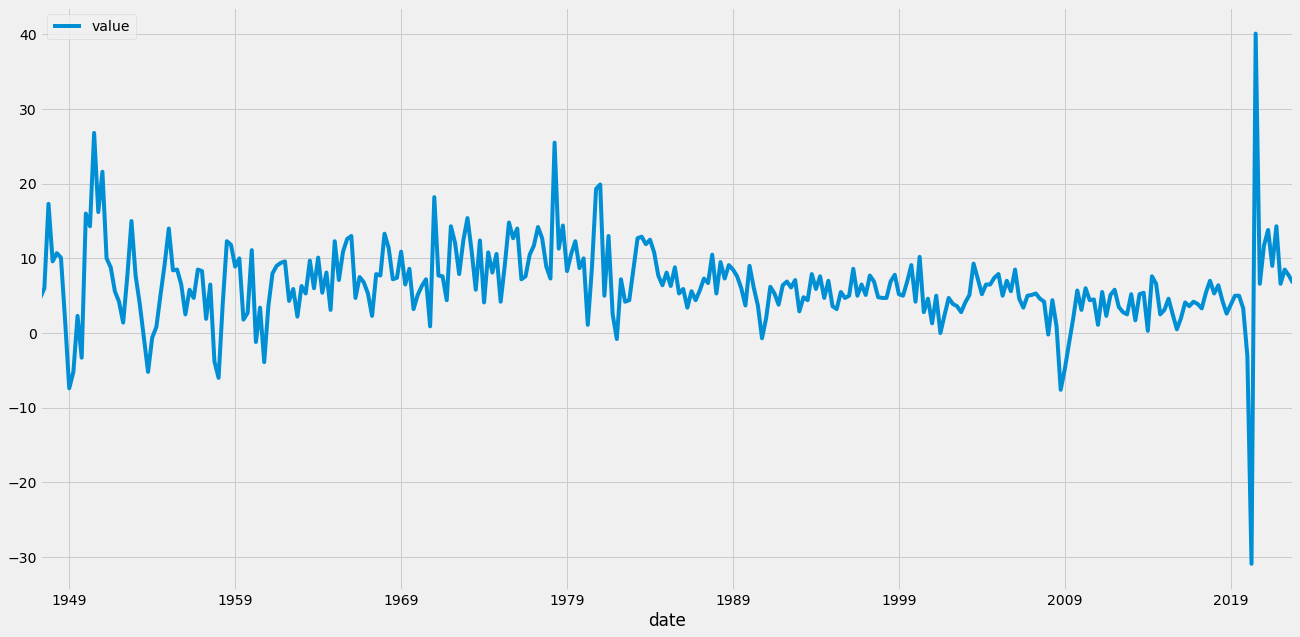

In [10]:
xdat = pd.read_csv("GDP.csv")
xdat.columns = ['date','value']
xdat['date'] = pd.to_datetime(xdat['date'])

xdat.set_index('date').plot()

## Seasonal Decomposition 

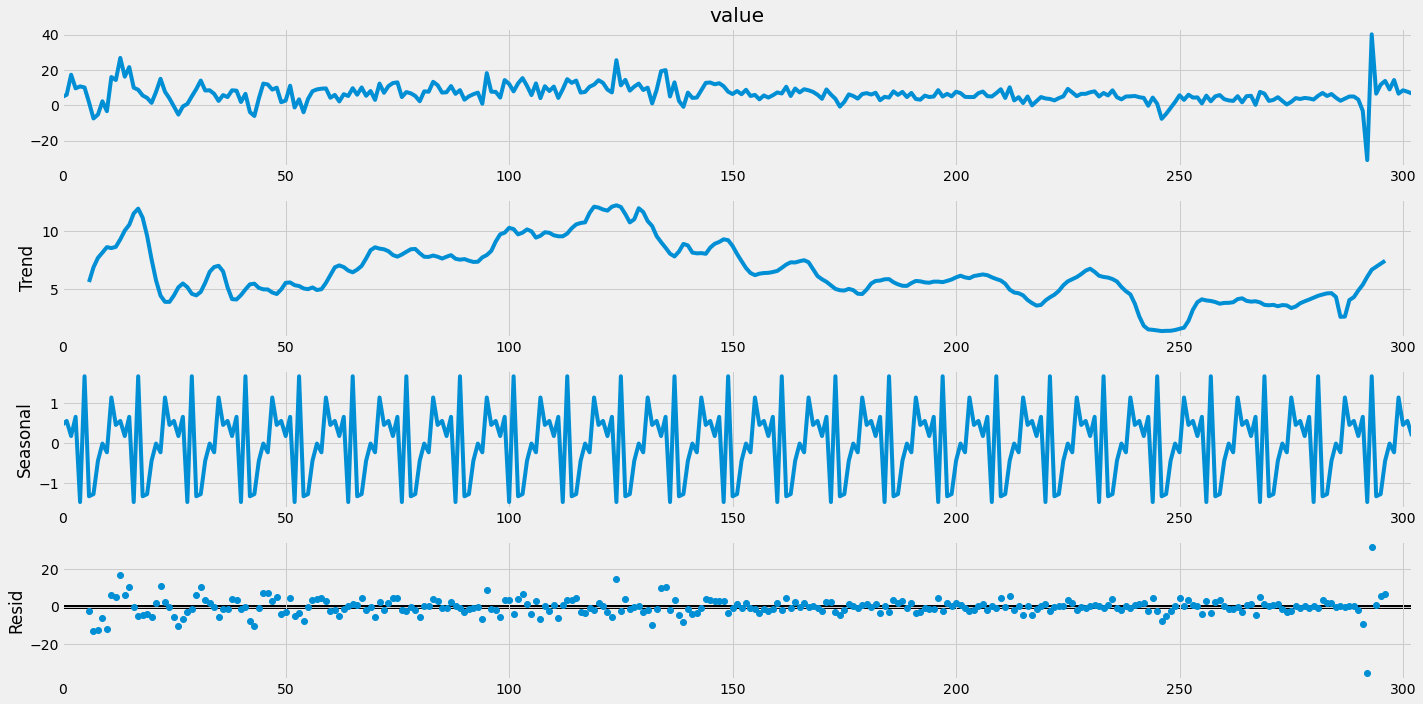

In [11]:
decomposition = sm.tsa.seasonal_decompose(xdat["value"],period =12, model = 'additive') 
figure = decomposition.plot()
plt.show()

        very less trend, and data seems seasonal. So lets see whether the data is stationary or not using Dickey Fuller test

The ADF test is used to determine the presence of a unit root in the time series. If the null hypothesis is rejected, it indicates that the time series is stationary. 

In [12]:
## ADF test
result = adfuller(xdat['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))    

ADF Statistic: -8.401847
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


    -- since p value < 0.05: reject H0: means data is stationary

## ARMA model building

    -- ACF is for MA Order
    -- PACF is for AR order

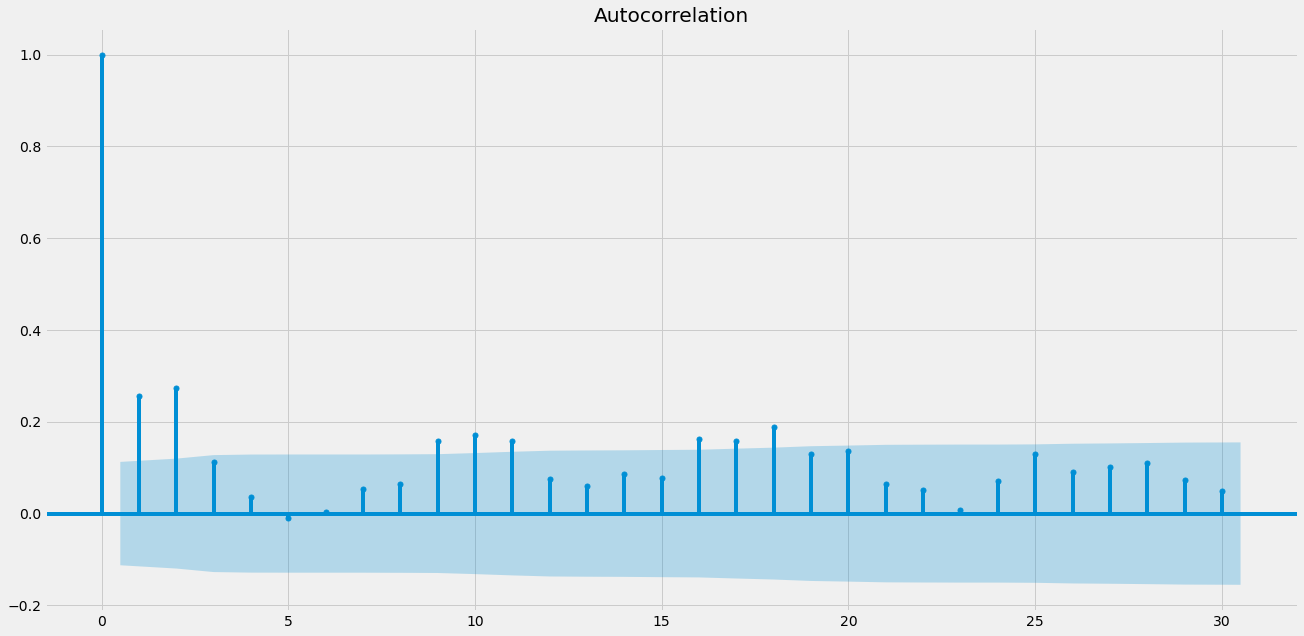

In [13]:
plot_acf(xdat['value'], lags = 30)
print()

        -- Seems like MA(2) model, don't worry about the spikes beyond lag 8 in this case

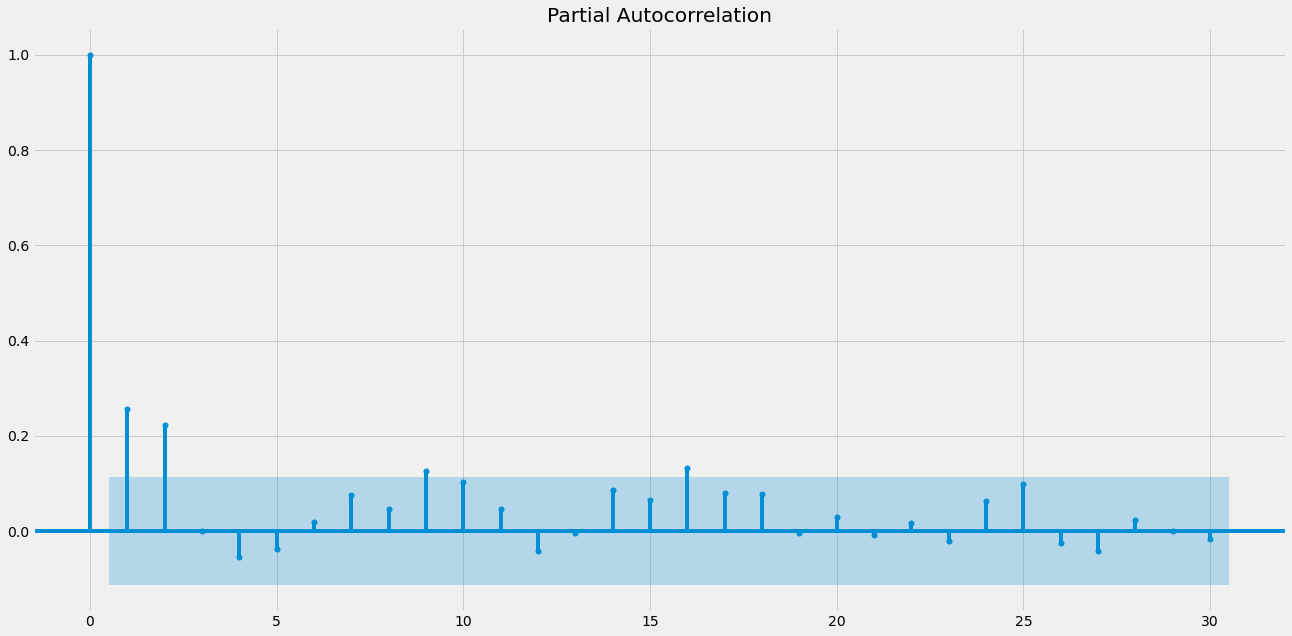

In [14]:
plot_pacf(xdat['value'], lags = 30)
print()

        -- Seems like AR(2) model

        -- So lets go for ARMA(2,2) model

In [15]:
## since quaterly data: so just taking the last 3 years as the testing dataset
xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size = 12)

## why Fourier?
    -- Any smooth function can be decomposed into a combination of sines and cosines with changing periods and amplitudes

# AutoArima
    -- It will find the optimal order for the time series    

In [16]:
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(xtrain)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1630.714, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1714.703, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1677.564, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1671.201, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1712.704, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1632.958, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1631.598, Time=0.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1621.638, Time=0.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1626.790, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1624.943, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1622.772, Time=0.80 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1625.059, Time=0.45 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1

Pipeline(steps=[('fourier', FourierFeaturizer(m=4)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=False, trace=1))])

## Inferences:
    -- seems like Arima(2,1,3) is the best model

In [17]:
pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  291
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -798.283
Date:                Fri, 24 Mar 2023   AIC                           1616.565
Time:                        19:21:28   BIC                           1653.264
Sample:                             0   HQIC                          1631.269
                                - 291                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
FOURIER_S4-0     0.1770      0.262      0.676      0.499      -0.336       0.690
FOURIER_C4-0    -0.0482      0.274     -0.176      0.860      -0.585       0.489
FOURIER_S4-1 -6.739e+04   2.85e+04     -2.362      0.018   -1.23e+05   -1.15e+04
FOURIER_C4-1     1.0867      0.327      3.323      0.001       0.446       1.728
ar.L1            1.4240      0.071     20.094      0.000       1.285       1.563
ar.L2           -0.8283      0.058    -14.340      0.000      -0.942      -0.715
ma.L1           -2.0636      0.086    -23.909      0.000      -2.233      -1.894
ma.L2            1.7046      0.137     12.478      0.000       1.437       1.972
ma.L3           -0.6056      0.072     -8.417      0.000      -0.747      -0.465
sigma2          14.2993      0.826     17.310      0.000      12.680      15.918
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                99.49
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## AIC - BIC
    -- The main table provides a summary of the sample size, probability, and information criteria. This is beneficial when choosing models based on simplicity. Information criteria, such as AIC, BIC, and HQIC, are used to balance model complexity (i.e., the number of parameters) and probability. The goal is to choose a model with the fewest parameters necessary to capture the nuances of our data generating process (DGP) without going overboard. An information criterion assesses how well a model fits the data while considering its overall complexity. A model that fits the data well but uses many parameters will have a higher AIC score than a model that achieves the same level of fit with fewer features.

## Jarque-Bera test
    -- Goodness of fit test, The Jarque-Bera test is a goodness-of-fit test that measures if sample data has skewness and kurtosis that are similar to a normal distribution. The Jarque-Bera test statistic is always positive, and if it is not close to zero, it shows that the sample data do not have a normal distribution.

## Ljung box Test
    -- The test is applied to the residuals of a time series after fitting an ARMA(p,q) model to the data. The test examines m autocorrelations of the residuals. If the autocorrelations are very small, we conclude that the model does not exhibit significant lack of fit. 

    -- The null hypothesis of the Ljung-Box test is that the autocorrelations (for the chosen lags) in the population from which the sample is taken are all zero

    -- The Ljung-Box test is a statistical test used to determine whether a set of observations from a time series are independently distributed. The test statistic is denoted by Q and is calculated based on the autocorrelation function (ACF) of the time series. The Ljung-Box (L1) (Q) value of 0.27 is a low value, indicating that there is no significant autocorrelation in the data up to the first lag (L1). This suggests that the observations in the time series are independently distributed and that there is no significant serial correlation. Therefore, the model may be a good fit for the data, and the residuals may be random noise. However, it is important to note that the interpretation of the Ljung-Box test should always be considered in conjunction with other diagnostic tests to ensure that the model is appropriate for the data.    

In [18]:
## forcasting

preds, conf_int = pipe.predict(n_periods= xvalid.shape[0], return_conf_int=True)
print("\nForecasts:")
print(preds)


Forecasts:
[3.66074061 5.07071927 3.52153223 4.47281048 3.23451391 4.79574001
 3.40636085 4.61321416 3.45320257 5.06750025 3.53556575 4.64874677]


In [19]:
print("\nConfidence intervals:")
print(conf_int)


Confidence intervals:
[[-3.75074103 11.07222226]
 [-2.80729405 12.94873259]
 [-4.7181897  11.76125415]
 [-3.9002277  12.84584865]
 [-5.14720514 11.61623295]
 [-3.59687338 13.18835341]
 [-5.01236202 11.82508372]
 [-3.81186603 13.03829435]
 [-4.97893423 11.88533938]
 [-3.42662208 13.56162258]
 [-5.07892451 12.15005601]
 [-4.08811957 13.38561311]]


## ARMA confidence intervals are based on a parametric approach:

    -- we assume the residual terms  ϵt have Gaussian distribution

    -- Gaussian is closed under addition  ⟹ Xt is Gaussian

    -- Hilbert projection theorem  ⟹ expected value is our best forecast wrt MSE

In [20]:
xvalid

291    -3.1
292   -30.9
293    40.1
294     6.6
295    11.7
296    13.8
297     9.0
298    14.3
299     6.6
300     8.5
301     7.7
302     6.7
Name: value, dtype: float64

<AxesSubplot:>

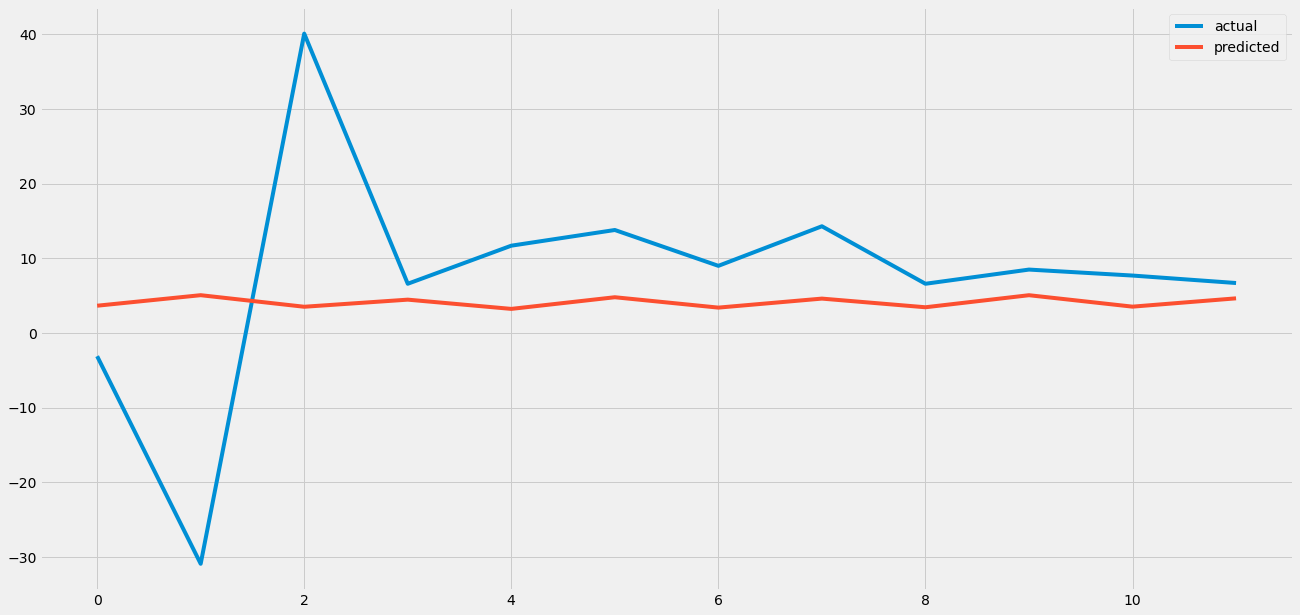

In [21]:
# let's quickly visualize the forecast
xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
xvalid['predicted'] = preds
xvalid.plot()

        -- Very Bad Fit

## Lets go with ARMA(2,2) model

<AxesSubplot:>

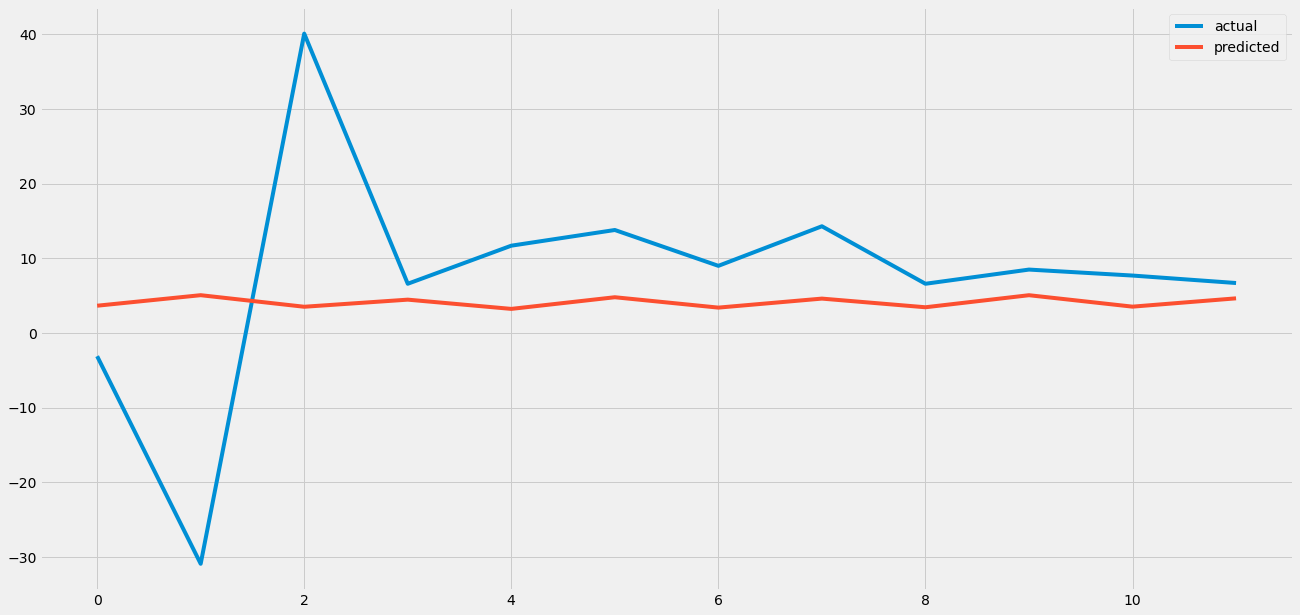

In [22]:
xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size = 12)

# Fit an ARMA(2,2) model to the data
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(xtrain, order=(2, 0, 2)) 
results = model.fit()


# Forecast the next 10 values
forecast = results.forecast(steps=xvalid.shape[0])

xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
xvalid['predicted'] = preds
xvalid.plot()




In [23]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Define a list to store the AIC values
aic_values = []

# Loop over all possible ARIMA models and calculate the AIC
for pi in p:
    for di in d:
        for qi in q:
            try:
                model = sm.tsa.ARIMA(xtrain, order=(pi, di, qi))
                results = model.fit()
                aic_values.append((pi, di, qi, results.aic))
            except:
                pass

# Find the ARIMA model with the lowest AIC
best_model = min(aic_values, key=lambda x: x[3])
print(f'Best ARIMA model: ARIMA{best_model[0], best_model[1], best_model[2]} with AIC {best_model[3]:.2f}')

Best ARIMA model: ARIMA(2, 1, 1) with AIC 1632.96


<AxesSubplot:>

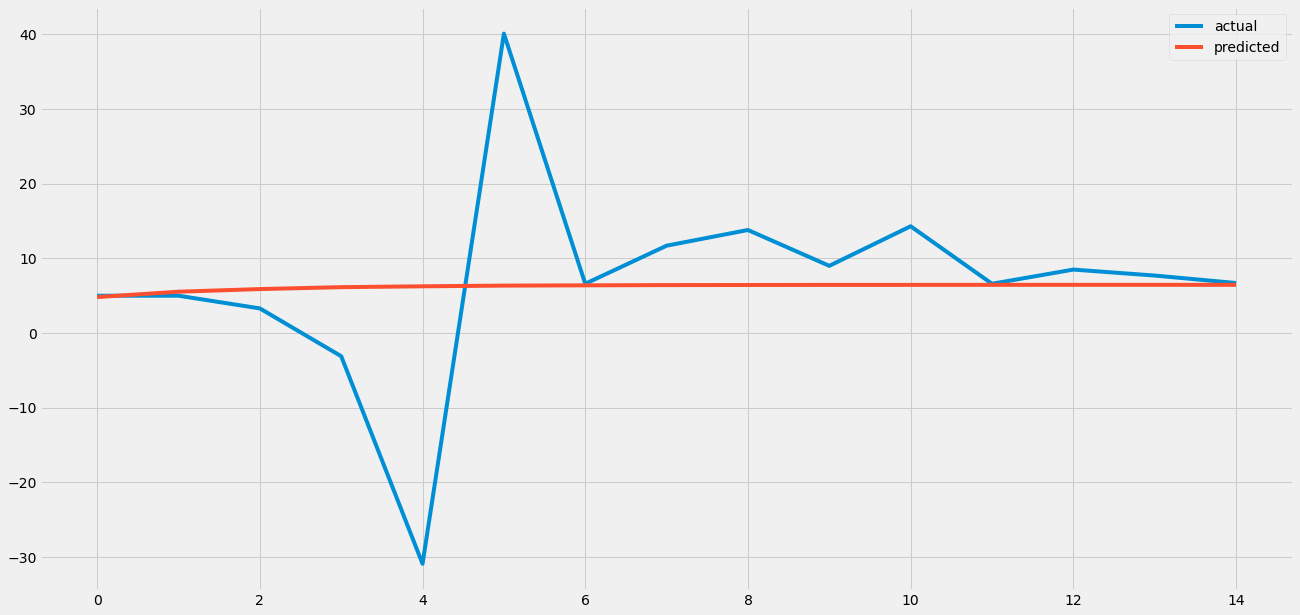

In [24]:
xtrain, xvalid = model_selection.train_test_split(xdat['value'], test_size = 15)

model = ARIMA(xtrain, order=(2, 0, 2)) 
results = model.fit()

# Forecast the next 10 values
forecast = results.forecast(steps=xvalid.shape[0])

xvalid = pd.DataFrame(xvalid.values, columns = ['actual'])
xvalid['predicted'] = forecast.values
xvalid.plot()

## Beyond ARMA

In [25]:
xdat = pd.read_csv("./archive/tesla_prices_5y.csv", usecols = ['Date','Close'])
xdat.columns = ['date','value']
xdat.head()

,date,value
0,2016-08-23,44.967999
1,2016-08-24,44.523998
2,2016-08-25,44.192001
3,2016-08-26,43.998001
4,2016-08-29,43.040001


<AxesSubplot:xlabel='date'>

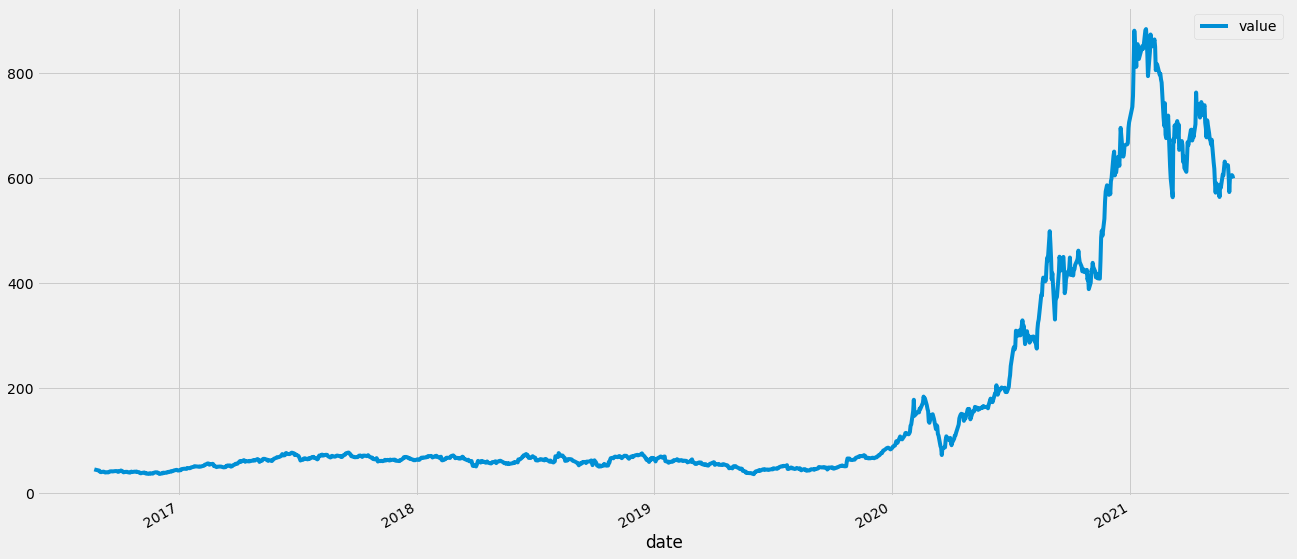

In [26]:
xdat['date'] = pd.to_datetime(xdat['date'])
xdat.set_index('date').plot()

In [27]:
## Lets see whether this is stationary or not:

result = adfuller(xdat['value'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.223000
p-value: 0.935724


        -- p value > 0.05: Accept H0: that is it is not stationary

## Differencing:

        -- Since non-stationary, lets take the first differencing to see whether it will be stationary or not

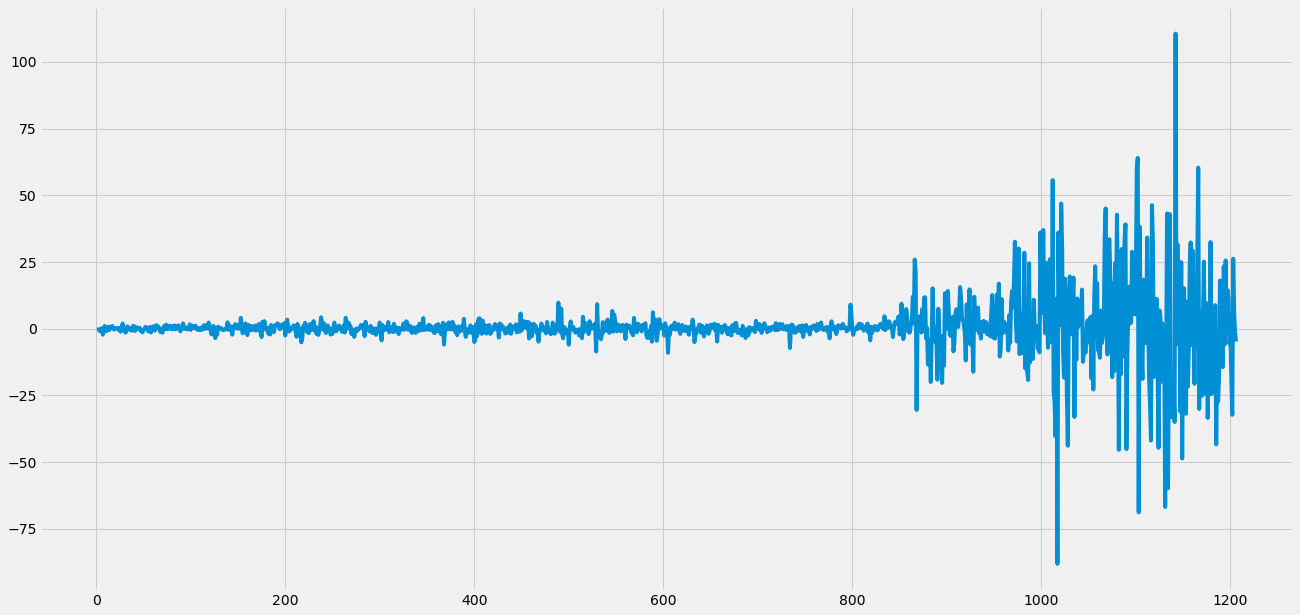

In [28]:
ydat = xdat['value'].diff()
ydat.plot()
print()

## seems like stationary to the naked eye

In [29]:
result = adfuller(ydat.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.940299
p-value: 0.000000


        -- p value < 0.05: so reject H0: it means data has become stationary

## SARIMA 

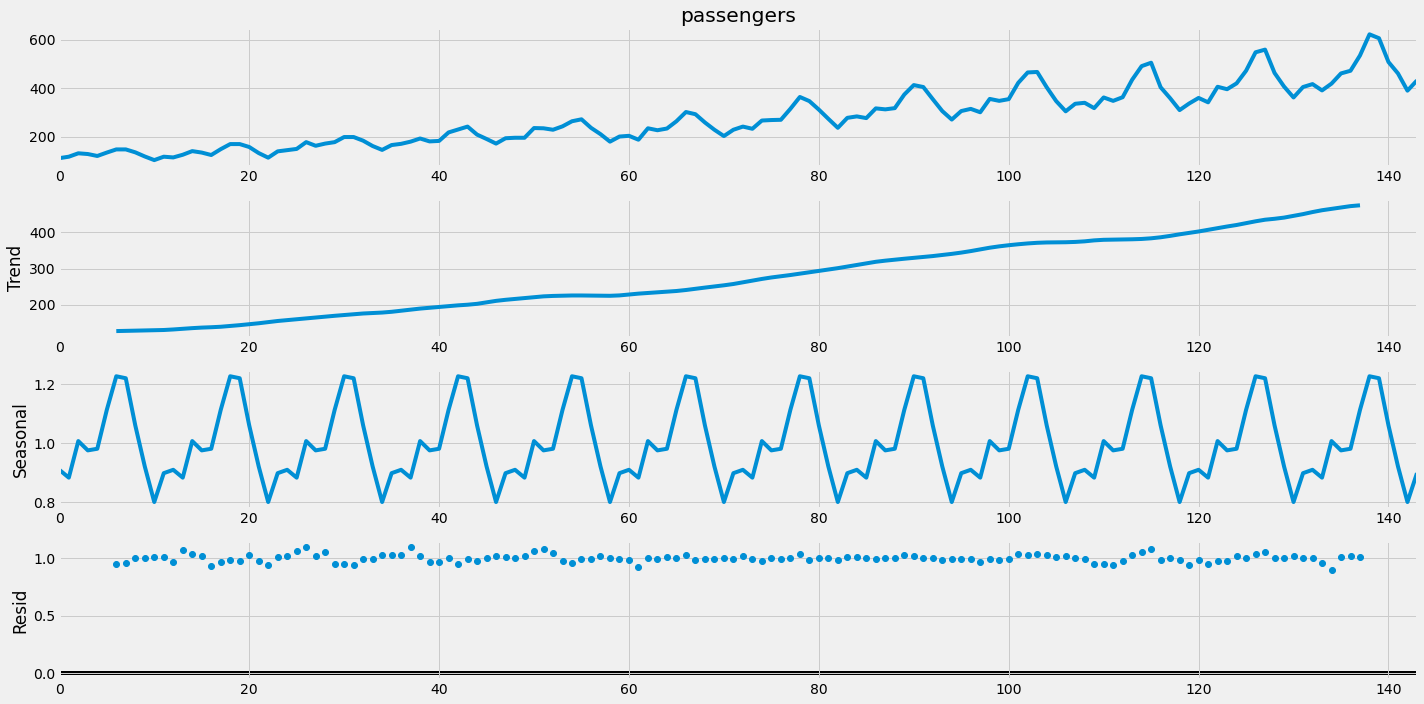

In [30]:
series = pd.read_csv('./archive/passengers.csv')
series['date'] = pd.to_datetime(series['date'])


decomposition = seasonal_decompose(series['passengers'], period = 12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

In [31]:
decomposition.seasonal

0      0.910230
1      0.883625
2      1.007366
3      0.975906
4      0.981378
         ...   
139    1.219911
140    1.060492
141    0.921757
142    0.801178
143    0.898824
Name: seasonal, Length: 144, dtype: float64

In [32]:
# check stationarity
result = adfuller(decomposition.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4370055100163737.000000
p-value: 0.000000


        -- Stationary dataset

c:\Users\Shankii\anaconda3\envs\gputest\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



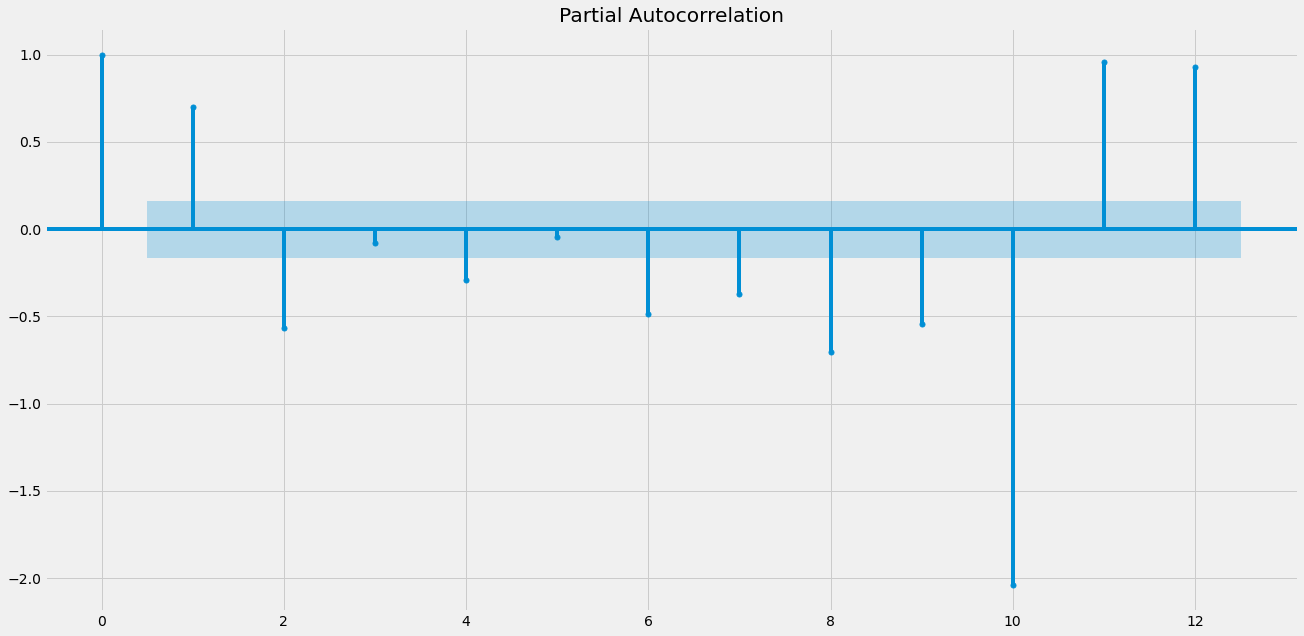

In [33]:
plot_pacf(decomposition.seasonal, lags = 12); print()